In [35]:
import pandas as pd
from dataprep.clean import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from optuna import create_study, visualization
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import RandomSampler
import shap
import matplotlib.pyplot as plt

import machine_learning_pipeline as mlp
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Wrangling

#### Loading train and test dfs

In [4]:
dataset_folder = 'S3 E26 Multi-Class Prediction of Cirrhosis Outcomes'

train_df = pd.read_csv(f'{dataset_folder}/train.csv')
test_df = pd.read_csv(f'{dataset_folder}/test.csv')

# cleaning the headers
train_df = clean_headers(train_df)
# confirming the id is unique for each row and setting it 
# as the index
assert train_df.id.nunique() == len(train_df)
train_df = train_df.set_index('id')

test_df = clean_headers(test_df)
assert test_df.id.nunique() == len(test_df)
test_df = test_df.set_index('id')

train_df

Column Headers Cleaning Report:
	19 values cleaned (95.0%)
Column Headers Cleaning Report:
	18 values cleaned (94.74%)


n_days             drug    age sex ascites hepatomegaly spiders edema  \
id                                                                            
0        999  D-penicillamine  21532   M       N            N       N     N   
1       2574          Placebo  19237   F       N            N       N     N   
2       3428          Placebo  13727   F       N            Y       Y     Y   
3       2576          Placebo  18460   F       N            N       N     N   
4        788          Placebo  16658   F       N            Y       N     N   
...      ...              ...    ...  ..     ...          ...     ...   ...   
7900    1166  D-penicillamine  16839   F       N            N       N     N   
7901    1492          Placebo  17031   F       N            Y       N     N   
7902    1576  D-penicillamine  25873   F       N            N       Y     S   
7903    3584  D-penicillamine  22960   M       N            Y       N     N   
7904    1978  D-penicillamine  19237   F       N            N       N     N   

      bilirubin  cholesterol  albumin  copper  alk_phos    sgot  \
id                                                                
0           2.3        316.0     3.35   172.0    1601.0  179.80   
1           0.9        364.0     3.54    63.0    1440.0  134.85   
2           3.3        299.0     3.55   131.0    1029.0  119.35   
3           0.6        256.0     3.50    58.0    1653.0   71.30   
4           1.1        346.0     3.65    63.0    1181.0  125.55   
...         ...          ...      ...     ...       ...     ...   
7900        0.8        309.0     3.56    38.0    1629.0   79.05   
7901        0.9        260.0     3.43    62.0    1440.0  142.00   
7902        2.0        225.0     3.19    51.0     933.0   69.75   
7903        0.7        248.0     2.75    32.0    1003.0   57.35   
7904        0.7        256.0     3.23    22.0     645.0   74.40   

      tryglicerides  platelets  prothrombin  stage status  
id                                                         
0              63.0      394.0          9.7    3.0      D  
1              88.0      361.0         11.0    3.0      C  
2              50.0      199.0         11.7    4.0      D  
3              96.0      269.0         10.7    3.0      C  
4              96.0      298.0         10.6    4.0      C  
...             ...        ...          ...    ...    ...  
7900          224.0      344.0          9.9    2.0      C  
7901           78.0      277.0         10.0    4.0      C  
7902           62.0      200.0         12.7    2.0      D  
7903          118.0      221.0         10.6    4.0      D  
7904           85.0      336.0         10.3    3.0      C  

[7905 rows x 19 columns]

#### Handling the Target/Dependent Variable

In [5]:
# assigning a column of the dataframe as the tarfet
target = 'status'
# defining the type of our target: 'continuous', 'binary' or 'multiclass'
target_type = 'multiclass'

# checking that the target_type is a valid one
assert target_type in ['continuous', 'binary', 'multiclass']

# encoding the target for categorical string target columns
if target_type != 'continuous':
    le = LabelEncoder()
    train_df[target] = le.fit_transform(train_df[target].tolist())
    target_classes = list(le.classes_)
    print('Target Encoding:')
    for i, clss in enumerate(target_classes): print(target + ' ' + str(clss) + ' -> ' + target + ' ' + str(i)) 

Target Encoding:
status C -> status 0
status CL -> status 1
status D -> status 2


#### Splitting features into numerical and categorical types

In [6]:
# creating a dataframe that lets us know the data types of each one of our 
# features
data_types = pd.DataFrame(train_df.dtypes, columns=['feature_type'])
data_types['unique_values'] = train_df.nunique()
data_types

feature_type  unique_values
n_days               int64            461
drug                object              2
age                  int64            391
sex                 object              2
ascites             object              2
hepatomegaly        object              2
spiders             object              2
edema               object              3
bilirubin          float64            111
cholesterol        float64            226
albumin            float64            160
copper             float64            171
alk_phos           float64            364
sgot               float64            206
tryglicerides      float64            154
platelets          float64            227
prothrombin        float64             49
stage              float64              4
status               int64              3

Although all the columns are numeric, the small number of diffetent values for some columns suggests that the they could be interpreted as categorical

In [7]:
# setting a threshold to determine categorical columns versus numerical
cat_threshold = 10
numerical_features, categorical_features = mlp.split_features(df=train_df, target_col=target, categorical_threshold=cat_threshold)

The numerical features are: ['bilirubin', 'cholesterol', 'albumin', 'copper', 'alk_phos', 'sgot', 'tryglicerides', 'platelets', 'prothrombin', 'stage', 'n_days', 'age']
The categorical features are: ['drug', 'sex', 'ascites', 'hepatomegaly', 'spiders', 'edema']


### EDA

#### Pairplot
These graphs help us visualize the relationships between our numerical features and the target. For numerical targets the last row of the pairplot corresponds to the target; for categorical targets, the target can be seen as the marker color in each graph.

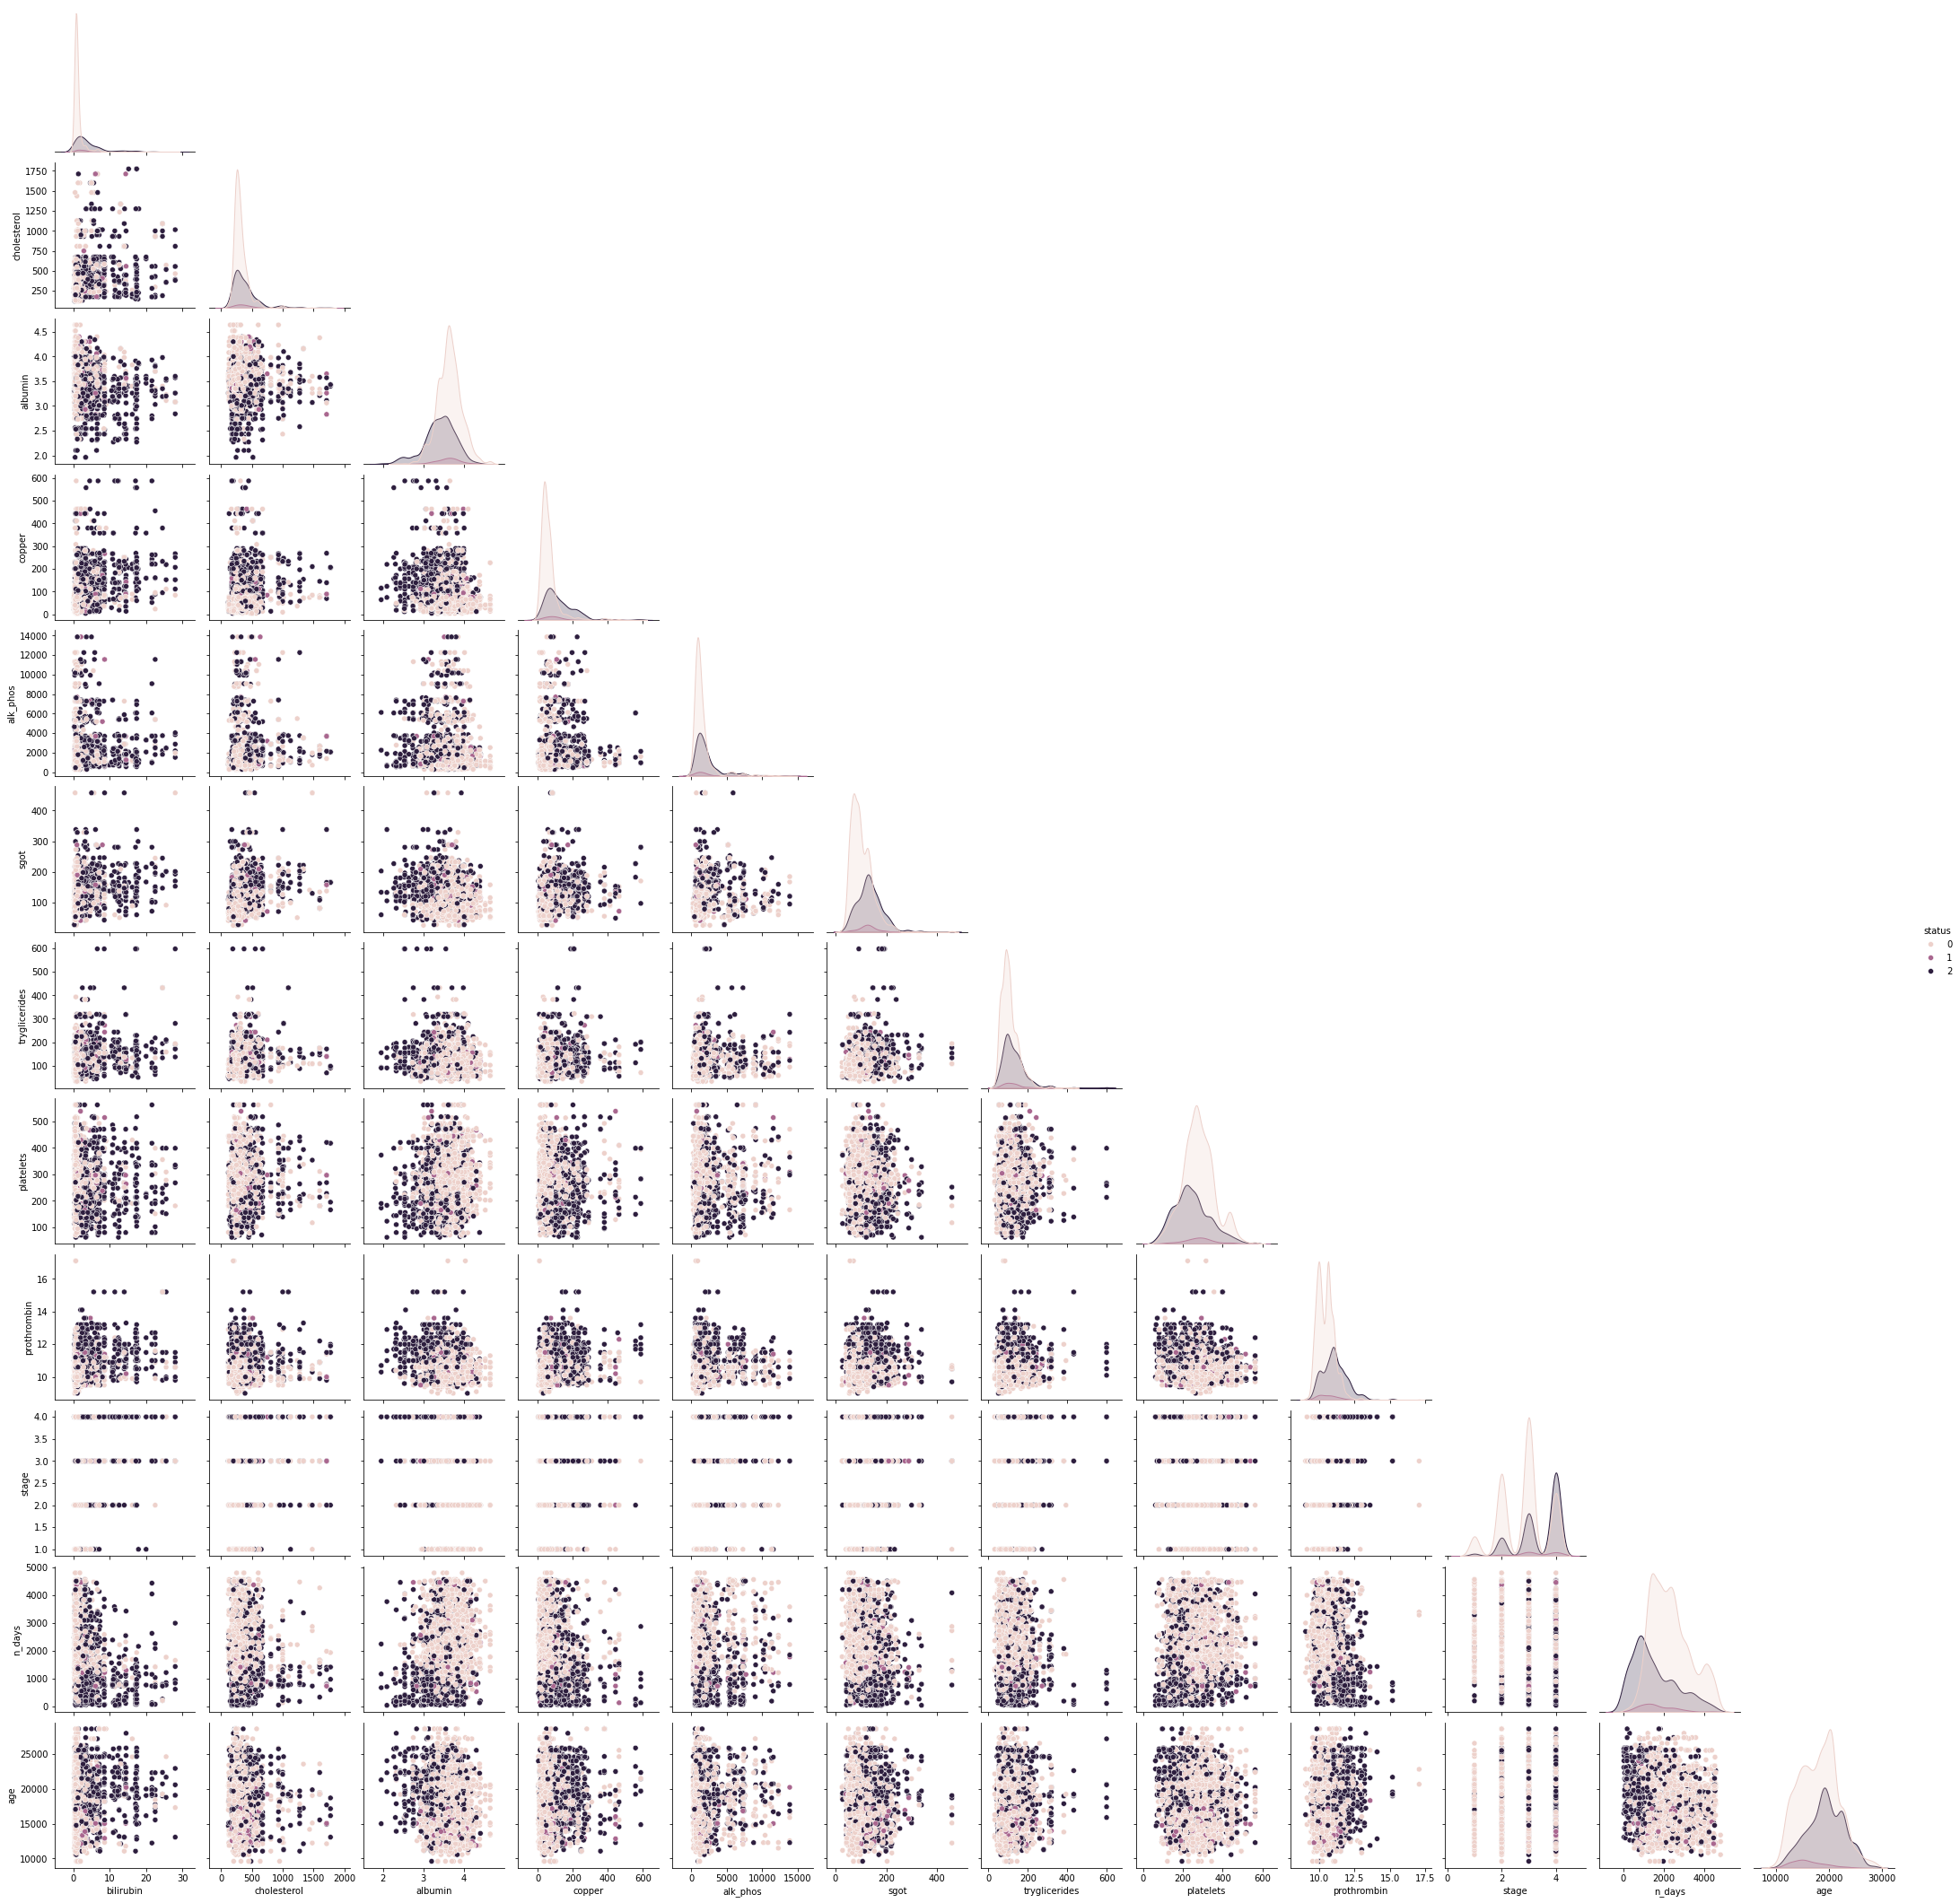

In [16]:
mlp.pairplot(df=train_df,
             numerical_features=numerical_features,
             target_type=target_type,
             target_col=target,
             sample=0.5)

#### Numerical Features Distribution Comparison
The graphs below are useful to identify any major differences between our train and test sets that can impact our models. It also shows the general distribution of each of the numerical features

In [17]:
mlp.train_test_distribution_plots(train_df,
                                  test_df,
                                  numerical_features,
                                  sample=0.5)

#### Categorical Features Distribution Comparison
The graphs below are useful to identify any major differences between our train and test sets that can impact our models. It also shows the general distribution of each of the cateorical features

In [8]:
mlp.train_test_categorical_piecharts(train_df,
                                     test_df,
                                     categorical_features)

#### Correlation Matrix

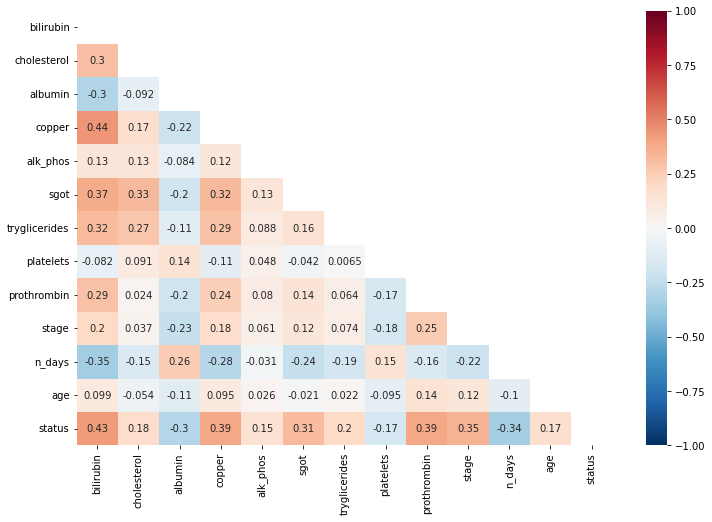

In [9]:
mlp.correlation_plot(train_df[numerical_features + [target]])

### Model Training with Optuna

#### Declaring variables needed for optimization step

In [10]:
# splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target, axis=1), 
                                                    train_df[target], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [11]:
# During the model fitting step, the optuna optimizer will include the algorithm 
# as one of the  hyperparameters of the model. It will try to find the one that 
# performs the best for our problem.

if target_type == 'continuous':    
    optimization_objective = 'regression'
    # available algorithms for regression tasks. 
    algorithms = [
                    'linear', 
                    'ridge',
                    'histgb',                     
                    'extratrees', 
                    'lgb',
                    'xgb', 
                    'catboost'
                ] 
    
    # scoring for cross-validation
    optimization_scoring = 'r2'

elif target_type == 'binary':
    optimization_objective = 'classification'
    # available algorithms for binary classification tasks
    algorithms = [
                    'histgb',                     
                    'extratrees', 
                    'lgb',
                    'xgb', 
                    'catboost'
                ]
    # scoring for cross-validation
    optimization_scoring = 'roc_auc'

elif target_type == 'multiclass':
    optimization_objective = 'multiclass'
    # available algorithms for multiclass classification tasks
    algorithms = [
                    'histgb',                     
                    'lgb',
                ]
    # scoring for cross-validation
    optimization_scoring = 'neg_log_loss'

#### Model Optimization

In [37]:
%%time
# declaring our optuna study
factor = 2
# the pruner parameter helps make the optimization much faster as it will prune
# any iterations that don't look promising right from the start
study = create_study(study_name='optimization', 
                     direction='maximize',
                     pruner=SuccessiveHalvingPruner(reduction_factor=factor),
                     sampler=RandomSampler(seed=0))


# custom function to fit the model using smart hyperparameter search with optuna. This 
# parameter search is not restricted to the algorithm's hyperparameters. The algorithm
# itself is part of the parameters to be optimized. Data preprocessing decisions are 
# also included here, such as the scaling approach for numerical features, the encoding 
# technique for categorical variables, as well as feature selection.
study.optimize(lambda trial: mlp.objective(trial, 
                                           X_train, 
                                           y_train, 
                                           objective=optimization_objective,
                                           algorithms=algorithms,
                                           cv_scoring=optimization_scoring,
                                           numerical_columns=numerical_features, 
                                           categorical_columns=categorical_features,
                                           base=factor, 
                                           n_rungs=4), 
               n_trials=10)

[I 2024-04-14 22:26:54,949] A new study created in memory with name: optimization
[I 2024-04-14 22:27:01,113] Trial 0 finished with value: -0.5633197921438244 and parameters: {'with_centering': False, 'with_scaling': True, 'categorical_encoder': 'target', 'algorithm': 'lgb', 'lambda_l1': 0.13351354975517513, 'lambda_l2': 0.0005755118598534656, 'num_leaves': 146, 'feature_fraction': 0.9553579829755966, 'bagging_fraction': 0.4426216349187322, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 0 with value: -0.5633197921438244.
[I 2024-04-14 22:27:03,411] Trial 1 finished with value: -0.45014385447731814 and parameters: {'with_centering': True, 'with_scaling': False, 'categorical_encoder': 'ordinal', 'algorithm': 'lgb', 'lambda_l1': 3.177022228527139, 'lambda_l2': 0.0004973188214118054, 'num_leaves': 107, 'feature_fraction': 0.5587333672627762, 'bagging_fraction': 0.86454021366053, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 1 with value: -0.45014385447731814.
[I 202

Wall time: 9.2 s


In [38]:
# saving the models best parameters and trial and printing its best score
best_model_params = study.best_params
best_trial = study.best_trial
# printing the score of the best model
print(study.best_value)

-0.45014385447731814


#### Optuna trials visualizations

In [39]:
visualization.plot_optimization_history(study)

In [40]:
visualization.plot_param_importances(study, target_name="ms")

#### Instantiating the model

In [41]:
# calling the best trial and instantiating the model
model = mlp.instantiate_model(best_trial, 
                              numerical_features, 
                              categorical_features, 
                              optimization_objective, 
                              algorithms)
model.fit(X_train, y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(with_scaling=False))]),
                                                  ['bilirubin', 'cholesterol',
                                                   'albumin', 'copper',
                                                   'alk_phos', 'sgot',
                                                   'tryglicerides', 'platelets',
                                                   'prothrombin', 'stage',
                                                   'n_days', 'age']),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['drug', 'sex', 'ascites',
                                                   'hepatomegaly', 'spiders',
                                                   'edema'])])),
                ('model',
                 LGBMClassifier(bagging_fraction=0.86454021366053,
                                bagging_freq=4,
                                feature_fraction=0.5587333672627762,
                                lambda_l1=3.177022228527139,
                                lambda_l2=0.0004973188214118054,
                                min_child_samples=59, num_leaves=107,
                                objective='multiclass', random_state=0,
                                verbosity=-1))])

In [42]:
# printing score on the test set
print(model.score(X_test,y_test))

0.8418722327640734


### Model Explainability with SHAP

#### Fitting the model on preprocessed data

In [43]:
best_model_params

{'with_centering': True,
 'with_scaling': False,
 'categorical_encoder': 'ordinal',
 'algorithm': 'lgb',
 'lambda_l1': 3.177022228527139,
 'lambda_l2': 0.0004973188214118054,
 'num_leaves': 107,
 'feature_fraction': 0.5587333672627762,
 'bagging_fraction': 0.86454021366053,
 'bagging_freq': 4,
 'min_child_samples': 59}

#### Applying preprocessing steps to our dataset and Fitting the model
To be able to compute the shap values we need the preprocessed dataset and the chosen model. We'll use the best_model_params dictionary to retrieve them

In [59]:
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from category_encoders import OrdinalEncoder, OneHotEncoder, WOEEncoder, TargetEncoder, CatBoostEncoder, SumEncoder, BinaryEncoder, HelmertEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer


# numerical_features_used = [col for col in numerical_features if best_model_params[col]]
numerical_features_used = numerical_features
# categorical_features_used = [col for col in categorical_features if best_model_params[col]]
categorical_features_used = categorical_features

X_train_preprocessed = X_train[numerical_features_used + categorical_features_used]
X_test_preprocessed = X_test[numerical_features_used + categorical_features_used]

valid_scaler_params = ['with_centering', 'with_scaling']
# Filter out non-preprocessing hyperparameters
preprocessing_params = {k: v for k, v in best_model_params.items() if k in valid_scaler_params}
final_scaler = RobustScaler(**preprocessing_params)

encoder_strategy = best_model_params['categorical_encoder']
if encoder_strategy == 'ordinal':
    encoder = OrdinalEncoder()
elif encoder_strategy == 'onehot':
    encoder = OneHotEncoder()
elif encoder_strategy == 'binary':
    encoder = BinaryEncoder()
elif encoder_strategy == 'helmert':
    encoder = HelmertEncoder()
elif encoder_strategy == 'sum':
    encoder = SumEncoder()
elif encoder_strategy == 'target':
    encoder = TargetEncoder()
elif encoder_strategy == 'woe':
    encoder = WOEEncoder()
elif encoder_strategy == 'catboost':
    encoder = CatBoostEncoder()
else:
    encoder = ''

final_processor = ColumnTransformer([
    ('scaler', final_scaler, numerical_features_used),
    ('encoder', encoder, categorical_features_used)
  ])

final_model_params = {k: v for k, v in best_model_params.items() if k not in (valid_scaler_params+['categorical_encoder'])}
del final_model_params['algorithm']
# for col in X_train.columns.to_list():
#     del final_model_params[col]
final_model_params['objective'] = 'multiclass'
# final_model = HistGradientBoostingRegressor(**final_model_params)
final_model = LGBMClassifier(**final_model_params, verbosity=-1)
# final_model = LinearRegression(**final_model_params)

X_train_preprocessed = final_processor.fit_transform(X_train_preprocessed, y_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=numerical_features + categorical_features, index=X_train.index)

X_test_preprocessed = final_processor.fit_transform(X_test_preprocessed, y_test)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=numerical_features + categorical_features, index=X_test.index)


final_model.fit(X_train_preprocessed, y_train)

LGBMClassifier(bagging_fraction=0.86454021366053, bagging_freq=4,
               feature_fraction=0.5587333672627762, lambda_l1=3.177022228527139,
               lambda_l2=0.0004973188214118054, min_child_samples=59,
               num_leaves=107, objective='multiclass', verbosity=-1)

#### Calculating Shap Values

In [45]:
explainer = shap.TreeExplainer(final_model)
# explainer = shap.Explainer(final_model, X_test_preprocessed)
shap_values = explainer.shap_values(X_train_preprocessed, y_train)

In [46]:
# making sure the labels are correct
data_types = pd.DataFrame(X_train_preprocessed.dtypes, columns=['feature_type'])
data_types['unique_values'] = X_train_preprocessed.nunique()
data_types

feature_type  unique_values
bilirubin          float64            108
cholesterol        float64            222
albumin            float64            158
copper             float64            170
alk_phos           float64            351
sgot               float64            202
tryglicerides      float64            151
platelets          float64            224
prothrombin        float64             49
stage              float64              4
n_days             float64            444
age                float64            378
drug               float64              2
sex                float64              2
ascites            float64              2
hepatomegaly       float64              2
spiders            float64              2
edema              float64              3

#### Shap summary plot

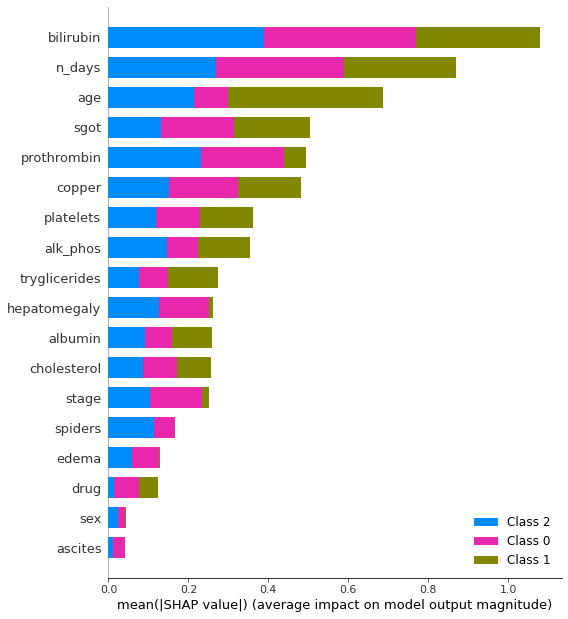

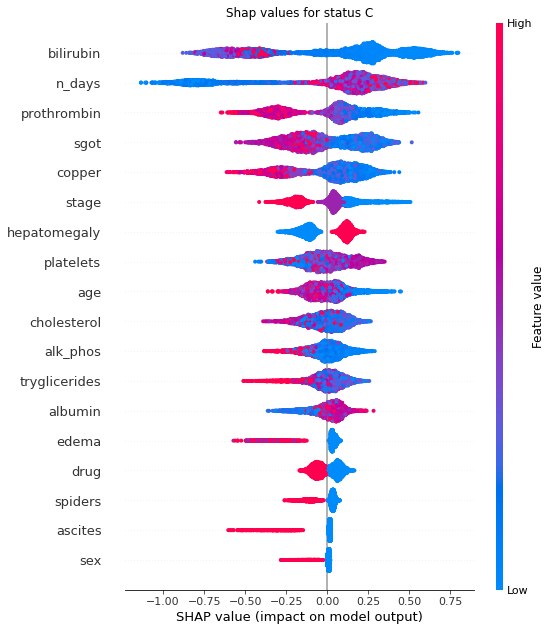

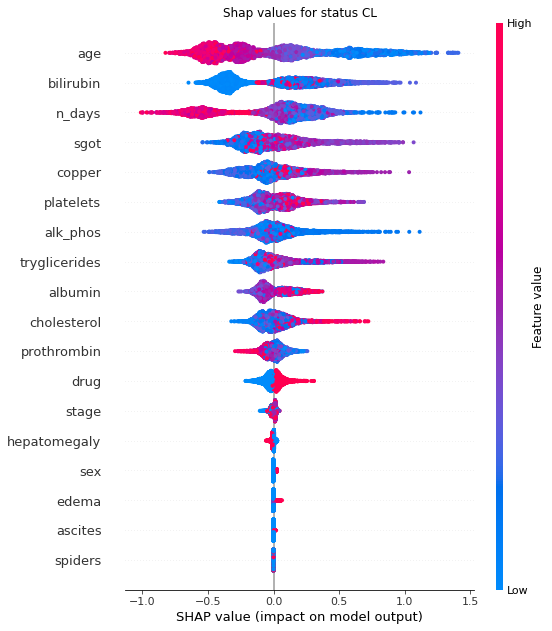

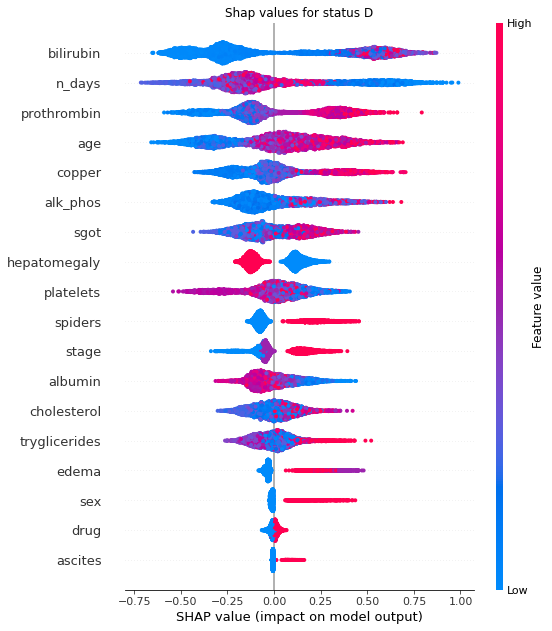

In [47]:
if target_type == 'continuous':     # graph not supported for multiclass
    shap.summary_plot(shap_values, 
                      X_train_preprocessed, 
                      feature_names=X_train_preprocessed.columns, 
                      plot_type='dot')
else:
    shap.summary_plot(shap_values, 
                      X_train_preprocessed, 
                      plot_type="bar", 
                      feature_names = X_train_preprocessed.columns)

    for i, tclass in enumerate(target_classes):
        shap.summary_plot(shap_values[i], 
                  X_train_preprocessed, 
                  plot_type="dot", 
                  feature_names = X_train_preprocessed.columns,
                  show=False) 
        plt.title(f'Shap values for {target} {tclass}')
        plt.show() 


#### Partial Dependence Plots

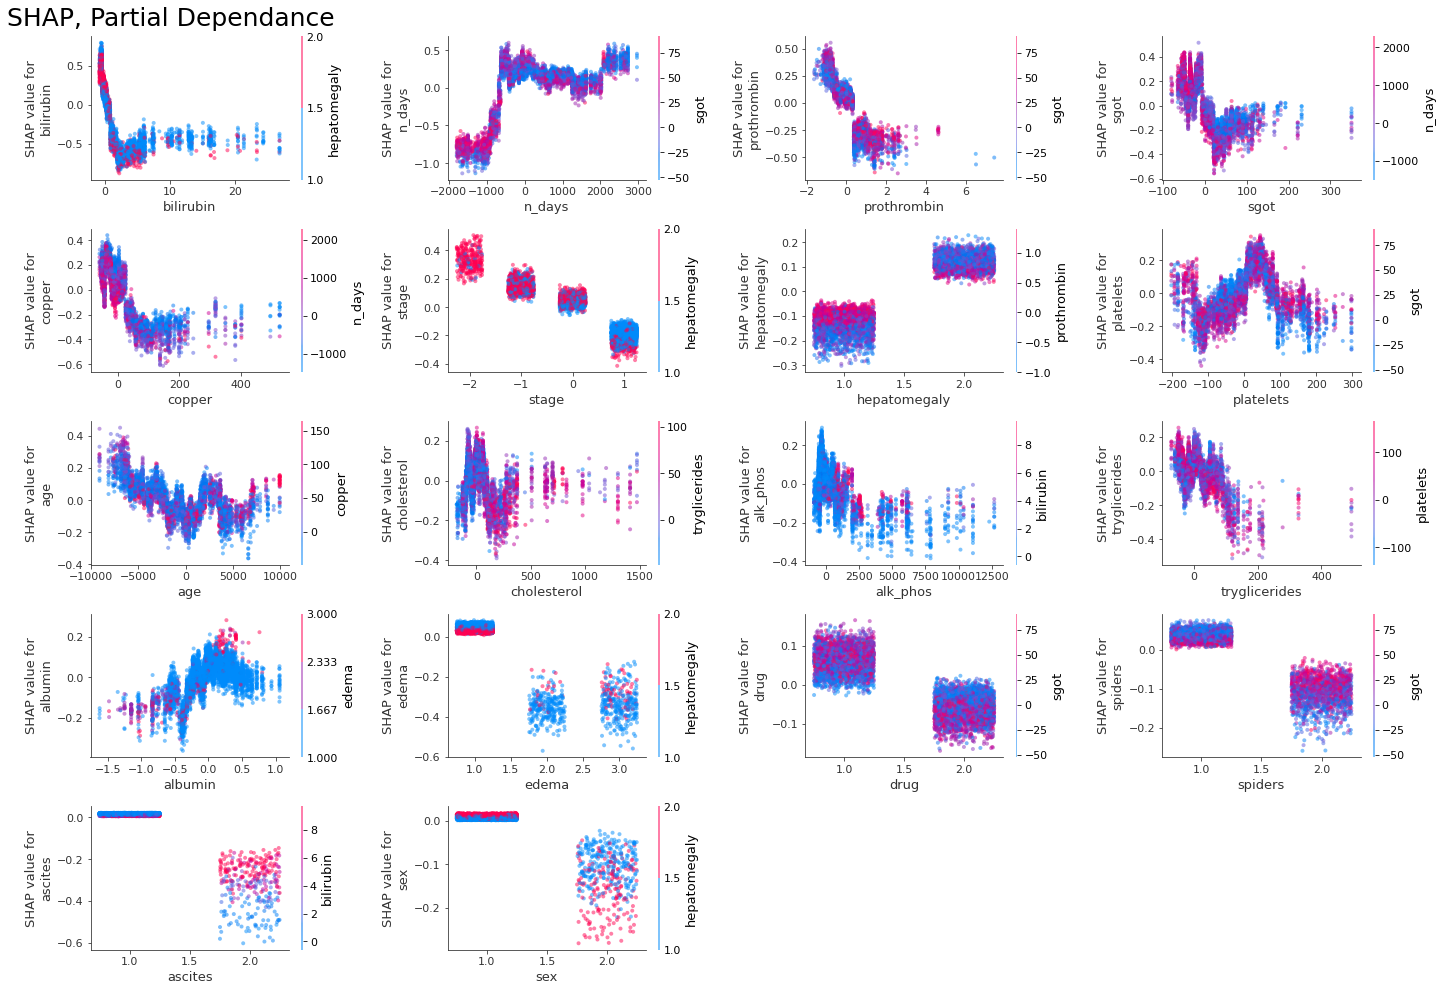

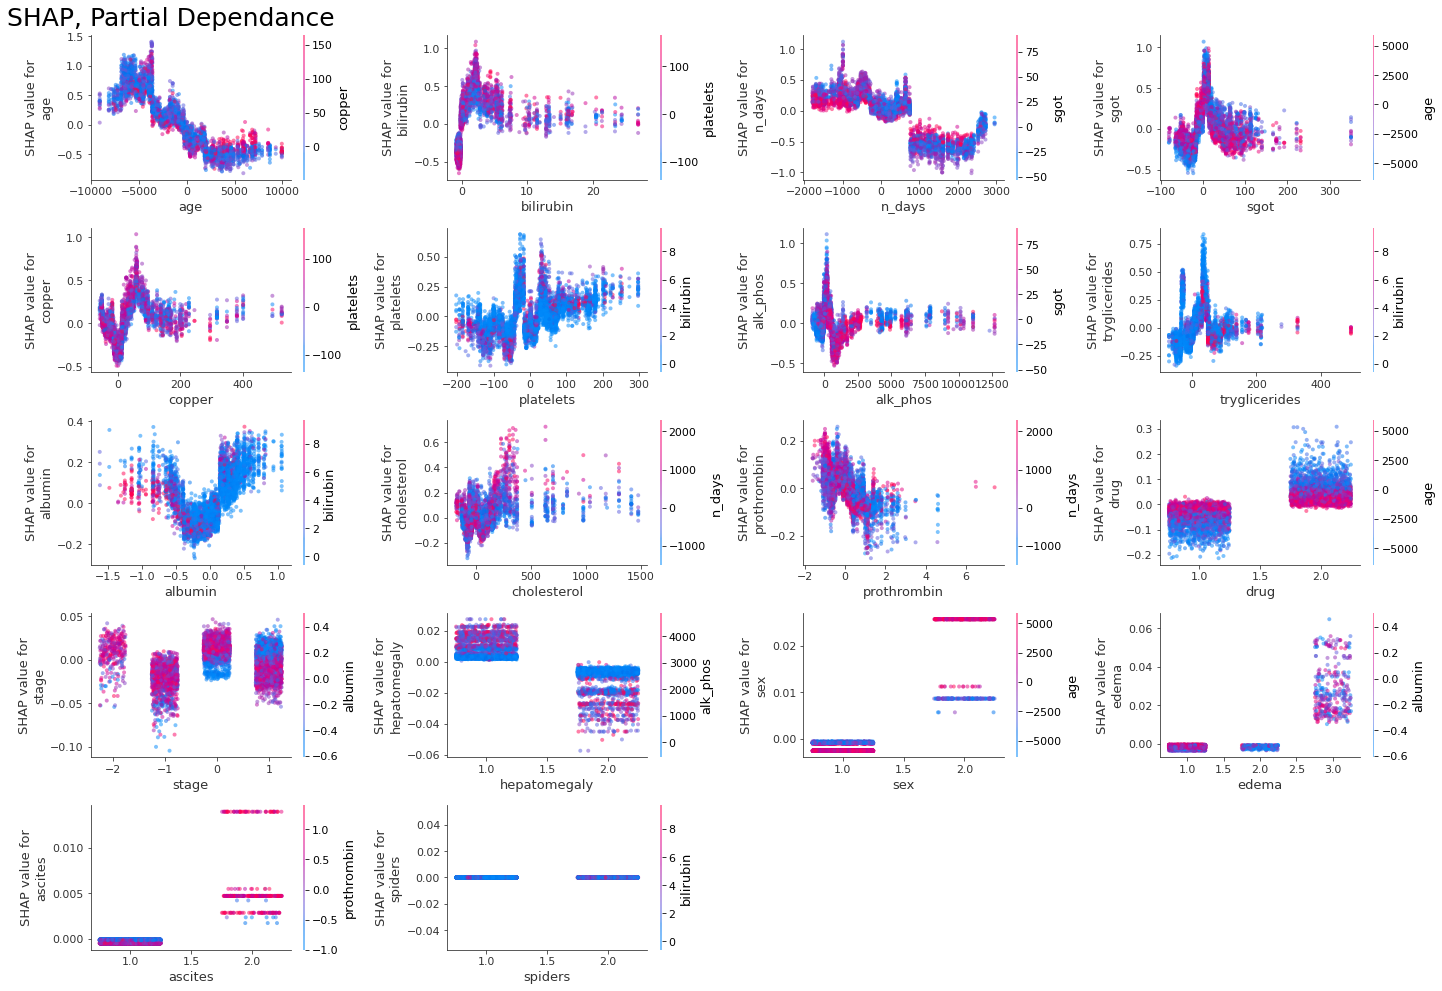

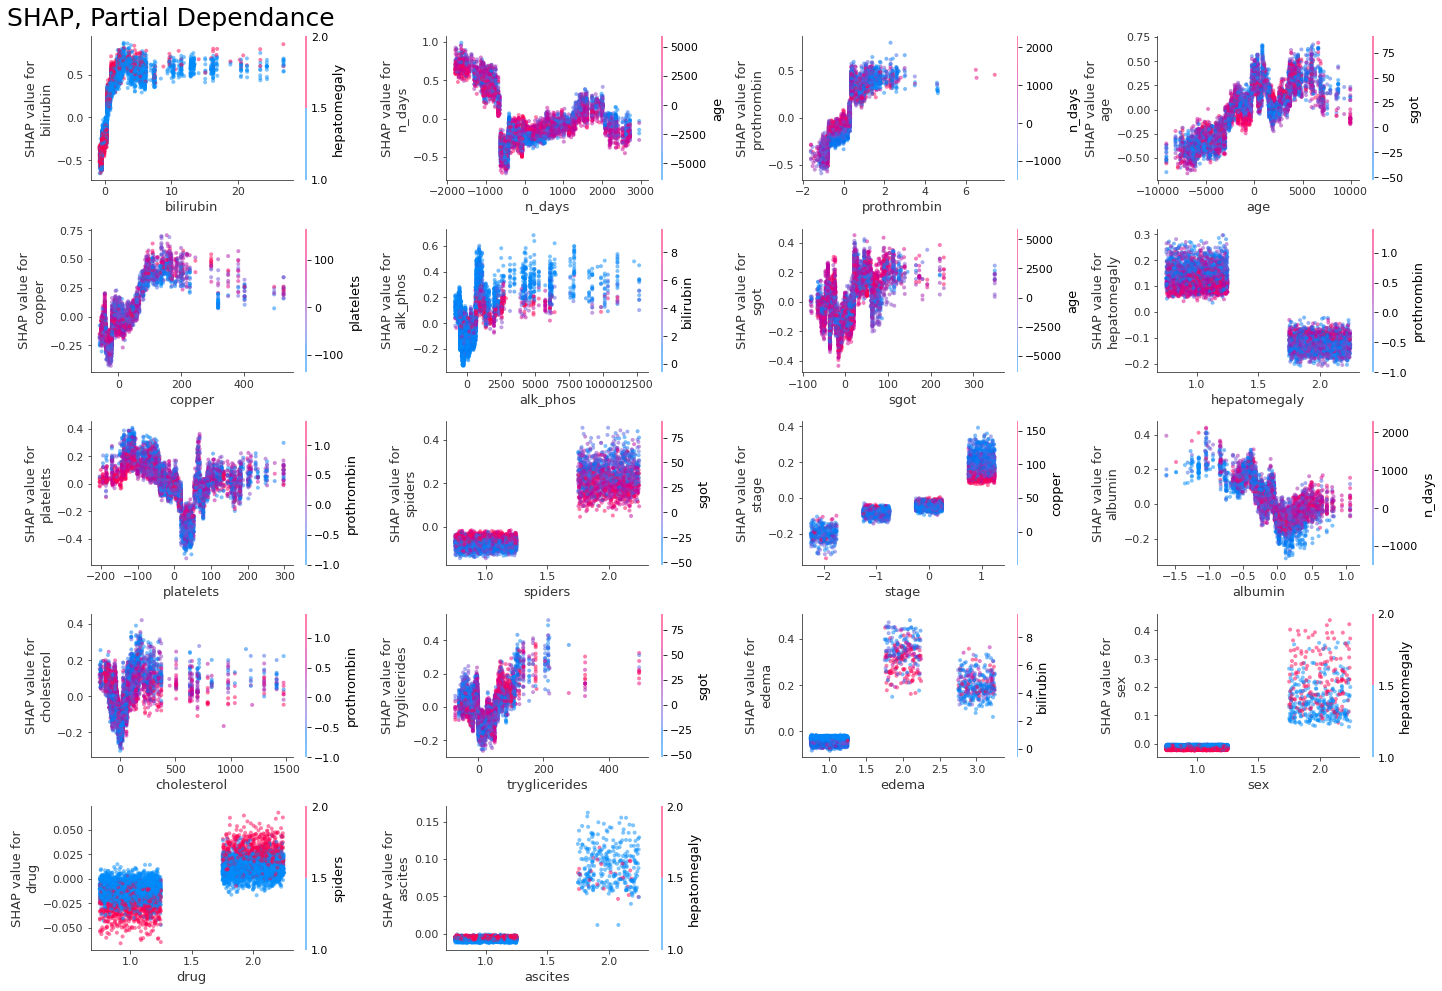

In [48]:
if target_type != 'continuous':
    # producing one graph for each class
    for i, tclass in enumerate(target_classes):
        mlp.shap_partial_dependence_plots(X_train_preprocessed, shap_values[i]) 
else:
    mlp.shap_partial_dependence_plots(X_train_preprocessed, shap_values)

Takeaways from the previous graphs: 

### Model Predictions Analysis

#### Train Set

In [49]:
if target_type == 'continuous':
    train_results = mlp.append_predictions(model=model, 
                                           df=X_train, 
                                           target_values=y_train,
                                           target_name=target,
                                           target_type=target_type, 
                                           df_preprocessed=X_train_preprocessed)
else:
    train_results = mlp.append_predictions(model=model, 
                                           df=X_train, 
                                           target_values=y_train,
                                           target_name=target,
                                           target_type=target_type, 
                                           df_preprocessed=X_train_preprocessed, 
                                           label_encoder=le)

train_results

id  bilirubin  cholesterol  albumin  copper  alk_phos   sgot  \
0     6703        0.3        121.0     0.25    16.0    -198.0  -9.30   
1     5815       -0.3        279.0    -0.23    14.0    -198.0   9.30   
2     3429       -0.5        279.0    -0.21    15.0    -198.0   9.30   
3     2405       -0.2         61.0     0.08    60.0     638.0  48.05   
4     1410        2.5        149.0    -0.35     2.0    -102.0 -46.50   
...    ...        ...          ...      ...     ...       ...    ...   
6319  5226        2.2         32.0    -0.12   164.0    4126.0 -54.25   
6320  5390       -0.2          1.0    -0.40   168.0     616.0  23.25   
6321   860       -0.3        -26.0     0.07   -15.0    -380.0 -54.25   
6322  7603        0.0        -43.0    -0.04   -21.0     -42.0 -32.55   
6323  7270       -0.6        -98.0     0.35   -21.0    -513.0 -52.70   

      tryglicerides  platelets  prothrombin  ...  sex  ascites  hepatomegaly  \
0             -49.0      -29.0         -0.7  ...  1.0      1.0           1.0   
1              73.0       41.0         -1.1  ...  1.0      1.0           2.0   
2              73.0       57.0         -1.1  ...  1.0      1.0           2.0   
3              50.0     -109.0          0.4  ...  1.0      1.0           1.0   
4             109.0     -146.0          1.1  ...  1.0      1.0           1.0   
...             ...        ...          ...  ...  ...      ...           ...   
6319           -5.0      -75.0         -0.2  ...  1.0      1.0           2.0   
6320           -5.0       54.0         -0.5  ...  1.0      1.0           1.0   
6321          110.0        4.0          0.0  ...  1.0      1.0           1.0   
6322          -10.0      -73.0         -0.1  ...  1.0      1.0           2.0   
6323          -14.0      -31.0          0.1  ...  1.0      1.0           1.0   

      spiders  edema  pred_prob_C  pred_prob_CL  pred_prob_D  \
0         1.0    1.0     0.531084      0.304413     0.164503   
1         1.0    1.0     0.903478      0.076537     0.019985   
2         1.0    1.0     0.960487      0.019280     0.020233   
3         1.0    1.0     0.466575      0.011968     0.521457   
4         2.0    1.0     0.091435      0.005006     0.903560   
...       ...    ...          ...           ...          ...   
6319      1.0    1.0     0.050002      0.011947     0.938051   
6320      2.0    1.0     0.075223      0.012430     0.912347   
6321      1.0    1.0     0.764409      0.027241     0.208351   
6322      1.0    1.0     0.912271      0.018271     0.069458   
6323      1.0    1.0     0.971376      0.002518     0.026106   

      status_prediction  status  
0                     C      CL  
1                     C       C  
2                     C       C  
3                     D       C  
4                     D       D  
...                 ...     ...  
6319                  D       D  
6320                  D       D  
6321                  C       C  
6322                  C       C  
6323                  C       C  

[6324 rows x 24 columns]

##### Overall Observations vs. Predictions plot

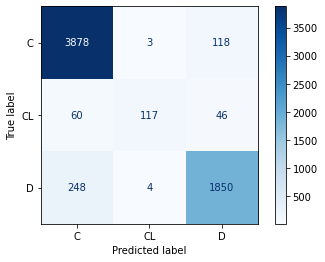

In [50]:
if target_type != 'continuous':
    target_classes = list(le.classes_)
    mlp.confusion_matrix_plot(y_true=train_results[target],
                              y_pred=train_results[target + '_prediction'],
                              labels=target_classes)

In [51]:
import plotly.express as px

if target_type == 'continuous':
    hover_col = 'id'
    fig = px.scatter(train_results, 
                     x=target, 
                     y=f"{target}_prediction", 
                     hover_data=[hover_col],
                     width=600,
                     height=600)
    fig.show()
else:
    mlp.prediction_probability_distribution_plot(preds_df=train_results, 
                                                 target_classes=target_classes, 
                                                 target_colname=target)


##### Single prediction waterfall plot

In [52]:
shap_explainer_values_train = explainer(X_train_preprocessed, y_train)

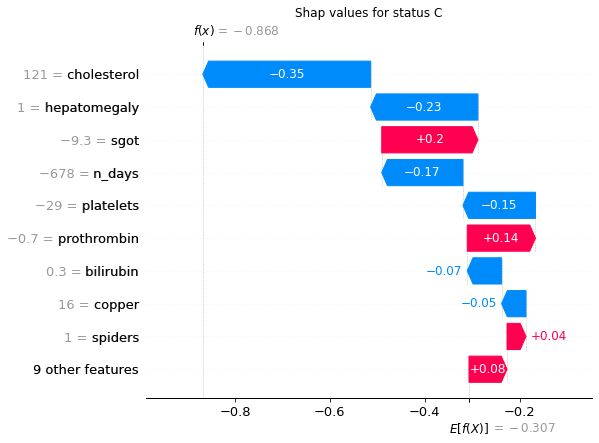

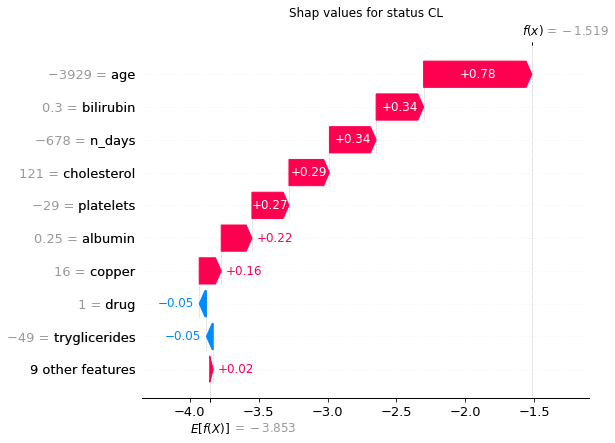

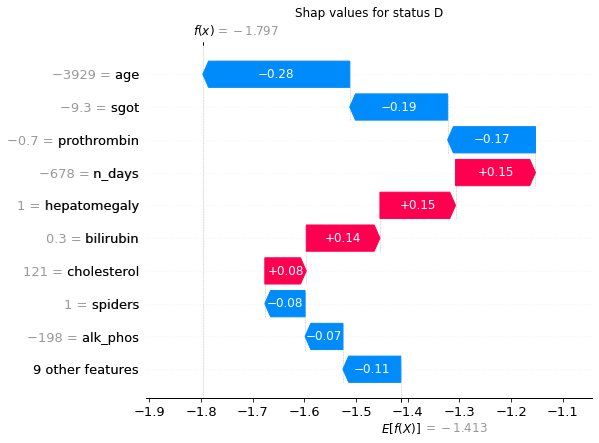

In [53]:
datapoint_id = 6703
idx = train_results[train_results.id == datapoint_id].index[0]
if target_type != 'multiclass':
    shap.waterfall_plot(shap_explainer_values_train[idx])
else:
    for i, tclass in enumerate(target_classes):
        shap.waterfall_plot(shap_explainer_values_train[idx][:,i], show=False)
        plt.title(f'Shap values for {target} {tclass}')
        plt.show()

#### Test Set

In [54]:
if target_type == 'continuous':
    test_results = mlp.append_predictions(model=model, 
                                          df=X_test, 
                                          target_values=y_test,
                                          target_name=target,
                                          target_type=target_type, 
                                          df_preprocessed=X_test_preprocessed)
else:
    test_results = mlp.append_predictions(model=model, 
                                          df=X_test, 
                                          target_values=y_test,
                                          target_name=target,
                                          target_type=target_type, 
                                          df_preprocessed=X_test_preprocessed, 
                                          label_encoder=le)

test_results

id  bilirubin  cholesterol  albumin  copper  alk_phos   sgot  \
0     3467       -0.3         30.0    -0.09     2.0    -502.0 -49.60   
1      465        2.2         63.0    -0.02   -29.0   11068.8 -37.20   
2      453        0.1        -66.0     0.39   -52.0    -116.0  -9.30   
3     4913       -0.7        -40.0     0.15   -14.0    -631.0 -66.65   
4     5907       -0.4         38.0    -0.23   -19.0     636.0 -12.40   
...    ...        ...          ...      ...     ...       ...    ...   
1576   622        2.2         74.0    -0.28    14.0    1086.0 -27.90   
1577  1419        0.4        134.0    -0.33     2.0    5266.2 -49.60   
1578  3934        0.7        -31.0     0.08    26.0    -436.0  86.80   
1579  7819        0.0         18.0    -0.16   -28.0     205.0  74.40   
1580  2432        4.5         40.0     0.11    67.0     949.0  74.95   

      tryglicerides  platelets  prothrombin  ...  sex  ascites  hepatomegaly  \
0             112.0        0.0         -0.8  ...  1.0      1.0           1.0   
1               3.0       76.0          0.0  ...  1.0      1.0           2.0   
2              -2.0      -42.0         -0.7  ...  2.0      1.0           1.0   
3              76.0       19.0         -0.1  ...  1.0      1.0           1.0   
4               9.0       -9.0         -1.1  ...  1.0      1.0           2.0   
...             ...        ...          ...  ...  ...      ...           ...   
1576           53.0       44.0          1.2  ...  1.0      1.0           2.0   
1577          112.0     -124.0          0.4  ...  1.0      1.0           2.0   
1578            5.0     -186.0         -0.3  ...  1.0      1.0           2.0   
1579          -30.0       63.0         -0.4  ...  1.0      1.0           1.0   
1580           92.0       89.0          0.3  ...  1.0      1.0           2.0   

      spiders  edema  pred_prob_C  pred_prob_CL  pred_prob_D  \
0         1.0    1.0     0.938764      0.005060     0.056176   
1         2.0    1.0     0.415049      0.053794     0.531158   
2         1.0    1.0     0.926600      0.019045     0.054355   
3         1.0    1.0     0.972872      0.002150     0.024978   
4         1.0    1.0     0.987953      0.001219     0.010828   
...       ...    ...          ...           ...          ...   
1576      2.0    1.0     0.049103      0.018577     0.932320   
1577      1.0    3.0     0.143309      0.005609     0.851083   
1578      2.0    1.0     0.596592      0.024083     0.379325   
1579      1.0    1.0     0.919078      0.049802     0.031120   
1580      1.0    1.0     0.563665      0.054808     0.381527   

      status_prediction  status  
0                     C       C  
1                     D       C  
2                     C       C  
3                     C       D  
4                     C       C  
...                 ...     ...  
1576                  D       D  
1577                  D       D  
1578                  C       C  
1579                  C       C  
1580                  C       D  

[1581 rows x 24 columns]

##### Overall Observations vs. Predictions plot

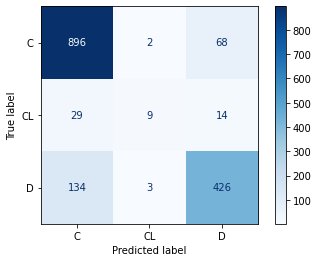

In [55]:
if target_type != 'continuous':
    target_classes = list(le.classes_)
    mlp.confusion_matrix_plot(y_true=test_results[target],
                              y_pred=test_results[target + '_prediction'],
                              labels=target_classes)

In [56]:
if target_type == 'continuous':
    hover_col = 'id'
    fig = px.scatter(test_results, 
                     x=target, 
                     y=f"{target}_prediction", 
                     hover_data=[hover_col],
                     width=600,
                     height=600)
    fig.show()
else:
    mlp.prediction_probability_distribution_plot(preds_df=test_results, 
                                                 target_classes=target_classes, 
                                                 target_colname=target)


##### Single prediction waterfall plot

In [57]:
shap_explainer_values_test = explainer(X_test_preprocessed, y_test)

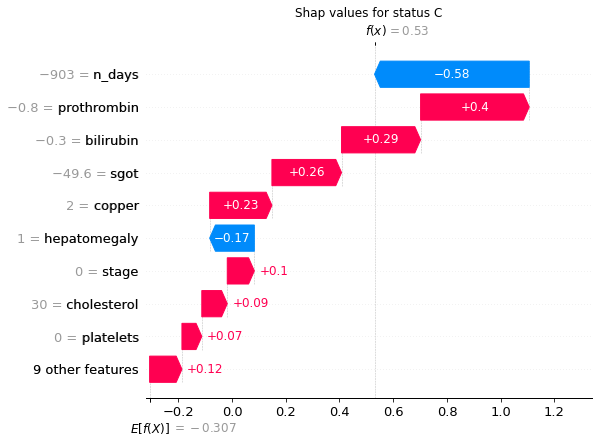

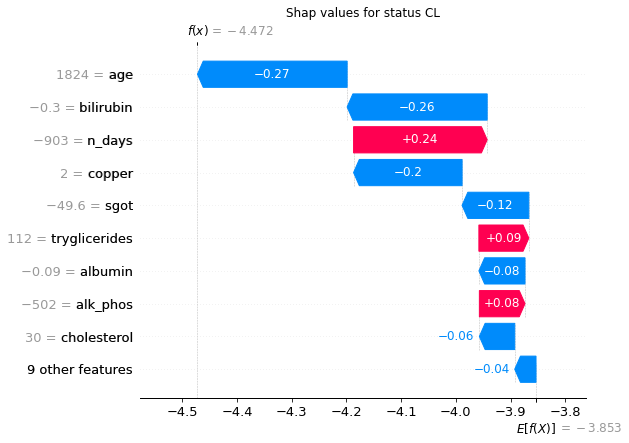

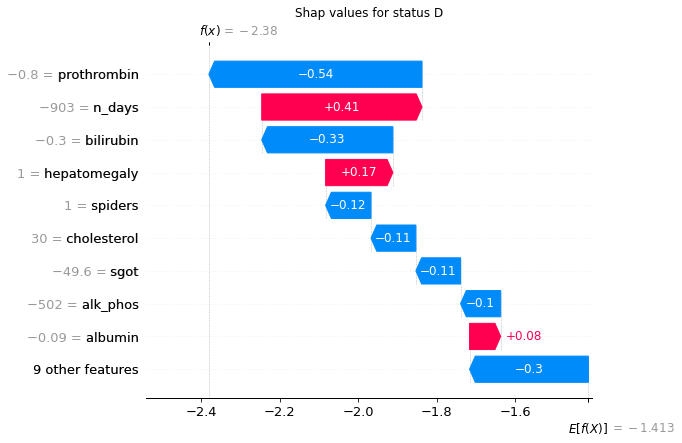

In [58]:
datapoint_id = 3467
idx = test_results[test_results.id == datapoint_id].index[0]
if target_type != 'multiclass':
    shap.waterfall_plot(shap_explainer_values_test[idx])
else:
    for i, tclass in enumerate(target_classes):
        shap.waterfall_plot(shap_explainer_values_test[idx][:,i], show=False)
        plt.title(f'Shap values for {target} {tclass}')
        plt.show()

### Conclusion